# Peter na Mbwa Mwitu: Utangulizi wa Kujifunza kwa Kuimarisha

Katika mafunzo haya, tutajifunza jinsi ya kutumia kujifunza kwa kuimarisha kutatua tatizo la kutafuta njia. Mazingira haya yamechochewa na hadithi ya muziki [Peter na Mbwa Mwitu](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) iliyoandikwa na mtunzi wa Kirusi [Sergei Prokofiev](https://en.wikipedia.org/wiki/Sergei_Prokofiev). Ni hadithi kuhusu mvumbuzi kijana Peter, ambaye kwa ujasiri anatoka nyumbani kwake kwenda kwenye uwazi wa msitu kumfuatilia mbwa mwitu. Tutafundisha algoriti za kujifunza kwa mashine ambazo zitamsaidia Peter kuchunguza eneo linalomzunguka na kujenga ramani bora ya urambazaji.

Kwanza, hebu tuagize maktaba kadhaa muhimu:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Muhtasari wa Kujifunza kwa Kuimarisha

**Kujifunza kwa Kuimarisha** (RL) ni mbinu ya kujifunza inayotuwezesha kujifunza tabia bora ya **wakala** katika **mazingira** fulani kwa kufanya majaribio mengi. Wakala katika mazingira haya anapaswa kuwa na **lengo**, linalofafanuliwa na **kazi ya zawadi**.

## Mazingira

Kwa urahisi, hebu tuchukulie ulimwengu wa Peter kuwa ubao wa mraba wa ukubwa `width` x `height`. Kila seli katika ubao huu inaweza kuwa:
* **ardhi**, ambapo Peter na viumbe wengine wanaweza kutembea
* **maji**, ambapo ni wazi huwezi kutembea
* **mti** au **nyasi** - mahali ambapo unaweza kupumzika kidogo
* **tufaha**, ambayo inawakilisha kitu ambacho Peter angefurahia kukipata ili kujilisha
* **mbwa mwitu**, ambaye ni hatari na anapaswa kuepukwa

Ili kufanya kazi na mazingira haya, tutafafanua darasa linaloitwa `Board`. Ili kuepuka kujaa sana katika daftari hili, tumetenganisha msimbo wote wa kufanya kazi na ubao katika moduli tofauti inayoitwa `rlboard`, ambayo sasa tutaiingiza. Unaweza kuangalia ndani ya moduli hii ili kupata maelezo zaidi kuhusu mambo ya ndani ya utekelezaji.


In [2]:
from rlboard import *

Hebu sasa tuunde ubao wa nasibu na tuone jinsi unavyoonekana:


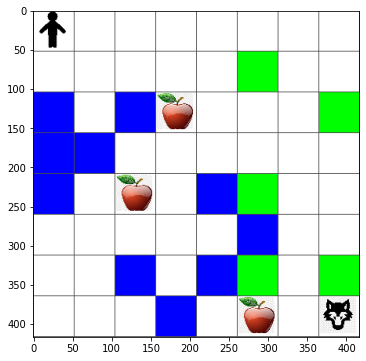

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Hatua na Sera

Katika mfano wetu, lengo la Peter litakuwa kupata tofaa, huku akiepuka mbwa mwitu na vikwazo vingine. Ili kufanya hivyo, anaweza kimsingi kutembea huku na huku hadi apate tofaa. Kwa hivyo, katika nafasi yoyote anaweza kuchagua mojawapo ya hatua zifuatazo: juu, chini, kushoto, na kulia. Tutafafanua hatua hizo kama kamusi, na kuzihusisha na jozi za mabadiliko ya kuratibu yanayolingana. Kwa mfano, kusonga kulia (`R`) kungefanana na jozi `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

Mkakati wa wakala wetu (Peter) unafafanuliwa na kile kinachoitwa **sera**. Hebu tuzingatie sera rahisi zaidi inayoitwa **kutembea bila mpangilio**.

## Kutembea bila mpangilio

Hebu kwanza tutatue tatizo letu kwa kutekeleza mkakati wa kutembea bila mpangilio.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Wacha tufanye jaribio la matembezi ya bahati nasibu mara kadhaa na tuone wastani wa idadi ya hatua zilizochukuliwa:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Kazi ya Zawadi

Ili kufanya sera yetu iwe na akili zaidi, tunahitaji kuelewa ni hatua zipi ni "bora" kuliko nyingine.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Kujifunza kwa Q

Jenga Jedwali la Q, au safu yenye vipimo vingi. Kwa kuwa ubao wetu una vipimo `width` x `height`, tunaweza kuwakilisha Jedwali la Q kwa safu ya numpy yenye umbo `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Pitisha Jedwali-Q kwenye kazi ya mchoro ili kuonyesha jedwali kwenye ubao:


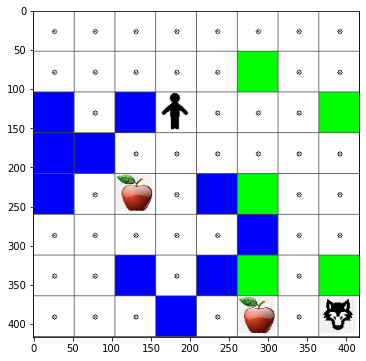

In [9]:
m.plot(Q)

## Kiini cha Q-Learning: Mlinganyo wa Bellman na Algorithimu ya Kujifunza

Andika pseudo-code kwa algorithimu yetu ya kujifunza:

* Anzisha Q-Table Q na namba sawa kwa hali zote na vitendo vyote
* Weka kiwango cha kujifunza $\alpha\leftarrow 1$
* Rudia simulizi mara nyingi
   1. Anza katika nafasi ya bahati nasibu
   1. Rudia
        1. Chagua kitendo $a$ katika hali $s$
        2. Tekeleza kitendo kwa kuhamia hali mpya $s'$
        3. Ikiwa tunakutana na hali ya mwisho wa mchezo, au jumla ya zawadi ni ndogo sana - toka kwenye simulizi  
        4. Hesabu zawadi $r$ katika hali mpya
        5. Sasisha Q-Function kulingana na mlinganyo wa Bellman: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Sasisha jumla ya zawadi na punguza $\alpha$.

## Kutumia vs. Kuchunguza

Njia bora ni kusawazisha kati ya kuchunguza na kutumia. Tunapojifunza zaidi kuhusu mazingira yetu, tutakuwa na uwezekano mkubwa wa kufuata njia bora, lakini kuchagua njia ambayo haijachunguzwa mara moja kwa wakati.

## Utekelezaji wa Python

Sasa tuko tayari kutekeleza algorithimu ya kujifunza. Kabla ya hilo, tunahitaji pia kazi fulani ambayo itabadilisha namba za bahati nasibu katika Q-Table kuwa vector ya uwezekano kwa vitendo vinavyolingana:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Tunaongeza kiasi kidogo cha `eps` kwenye vector ya asili ili kuepuka kugawanya kwa 0 katika hali ya awali, ambapo vipengele vyote vya vector ni sawa.

Algoriti halisi ya kujifunza tutakayoendesha kwa majaribio 5000, pia inaitwa **epochs**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Baada ya kutekeleza algoriti hii, Jedwali la Q linapaswa kusasishwa na maadili yanayofafanua mvuto wa vitendo tofauti katika kila hatua. Onyesha jedwali hapa:


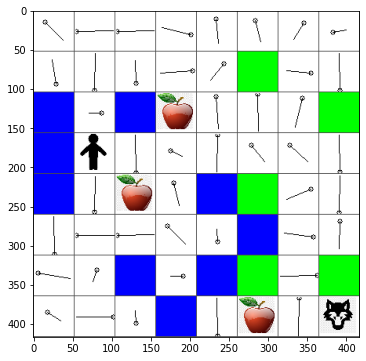

In [12]:
m.plot(Q)

## Kukagua Sera

Kwa kuwa Q-Table inaorodhesha "mvuto" wa kila kitendo katika kila hali, ni rahisi kuitumia kufafanua urambazaji bora katika ulimwengu wetu. Katika hali rahisi zaidi, tunaweza tu kuchagua kitendo kinacholingana na thamani ya juu zaidi katika Q-Table:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Ikiwa unajaribu msimbo hapo juu mara kadhaa, unaweza kugundua kwamba wakati mwingine unakwama tu, na unahitaji kubonyeza kitufe cha STOP kwenye daftari ili kuusimamisha. 

> **Kazi ya 1:** Badilisha kazi ya `walk` ili kuweka kikomo cha urefu wa njia kwa idadi fulani ya hatua (sema, 100), na angalia msimbo hapo juu ukirudisha thamani hii mara kwa mara.

> **Kazi ya 2:** Badilisha kazi ya `walk` ili isirudi kwenye maeneo ambayo tayari imekuwa hapo awali. Hii itazuia `walk` kurudia, hata hivyo, wakala bado anaweza kujikuta "amekwama" katika eneo ambalo hawezi kutoroka.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


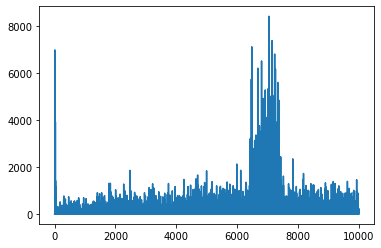

In [15]:
plt.plot(lpath)

Kile tunachokiona hapa ni kwamba mwanzoni urefu wa njia ya wastani uliongezeka. Hii huenda inatokana na ukweli kwamba tunapokuwa hatujui chochote kuhusu mazingira - tuna uwezekano mkubwa wa kujikuta katika hali mbaya, maji au mbwa mwitu. Tunapojifunza zaidi na kuanza kutumia maarifa haya, tunaweza kuchunguza mazingira kwa muda mrefu zaidi, lakini bado hatujui vizuri mahali ambapo tufaha zipo.

Mara tu tunapojifunza vya kutosha, inakuwa rahisi kwa wakala kufanikisha lengo, na urefu wa njia huanza kupungua. Hata hivyo, bado tunakuwa wazi kwa uchunguzi, kwa hivyo mara nyingi tunatoka nje ya njia bora, na kuchunguza chaguo mpya, jambo ambalo hufanya njia kuwa ndefu zaidi kuliko inavyopaswa.

Kile tunachokiona pia kwenye grafu hii, ni kwamba wakati fulani urefu uliongezeka ghafla. Hii inaonyesha asili ya mchakato wa nasibu, na kwamba tunaweza wakati fulani "kuharibu" viwango vya Q-Table, kwa kuandika upya thamani mpya. Hili linapaswa kupunguzwa kwa kupunguza kiwango cha kujifunza (yaani, kuelekea mwisho wa mafunzo tunarekebisha thamani za Q-Table kwa thamani ndogo).

Kwa ujumla, ni muhimu kukumbuka kwamba mafanikio na ubora wa mchakato wa kujifunza unategemea sana vigezo, kama vile kiwango cha kujifunza, kupungua kwa kiwango cha kujifunza, na kipengele cha punguzo. Hivi mara nyingi huitwa **vigezo vya juu**, ili kuvitofautisha na **vigezo** ambavyo tunaboresha wakati wa mafunzo (mfano, viwango vya Q-Table). Mchakato wa kutafuta thamani bora za vigezo vya juu huitwa **ubunifu wa vigezo vya juu**, na unastahili mada tofauti kabisa.


## Zoezi
#### Ulimwengu Halisi Zaidi wa Peter na Mbwa Mwitu

Katika hali yetu, Peter aliweza kusafiri karibu bila kuchoka au kuhisi njaa. Katika ulimwengu halisi zaidi, anapaswa kukaa chini na kupumzika mara kwa mara, na pia kujilisha. Hebu tufanye ulimwengu wetu uwe halisi zaidi kwa kutekeleza sheria zifuatazo:

1. Kwa kusafiri kutoka sehemu moja hadi nyingine, Peter hupoteza **nguvu** na kupata **uchovu**.
2. Peter anaweza kupata nguvu zaidi kwa kula matufaha.
3. Peter anaweza kuondoa uchovu kwa kupumzika chini ya mti au kwenye nyasi (yaani, kutembea hadi eneo la ubao lenye mti au nyasi - uwanja wa kijani).
4. Peter anahitaji kumtafuta na kumuua mbwa mwitu.
5. Ili kumuua mbwa mwitu, Peter anahitaji kuwa na viwango fulani vya nguvu na uchovu, vinginevyo atashindwa katika vita.

Badilisha kazi ya malipo hapo juu kulingana na sheria za mchezo, endesha algoriti ya kujifunza kwa kuimarisha ili kujifunza mkakati bora wa kushinda mchezo, na linganisha matokeo ya kutembea bila mpangilio na algoriti yako kwa kuzingatia idadi ya michezo iliyoshinda na kupotezwa.

> **Note**: Unaweza kuhitaji kurekebisha hyperparameters ili ifanye kazi, hasa idadi ya epochs. Kwa sababu mafanikio ya mchezo (kupigana na mbwa mwitu) ni tukio nadra, unaweza kutarajia muda mrefu zaidi wa mafunzo.



---

**Kanusho**:  
Hati hii imetafsiriwa kwa kutumia huduma ya kutafsiri ya AI [Co-op Translator](https://github.com/Azure/co-op-translator). Ingawa tunajitahidi kuhakikisha usahihi, tafadhali fahamu kuwa tafsiri za kiotomatiki zinaweza kuwa na makosa au kutokuwa sahihi. Hati ya asili katika lugha yake ya awali inapaswa kuzingatiwa kama chanzo cha mamlaka. Kwa taarifa muhimu, tafsiri ya kitaalamu ya binadamu inapendekezwa. Hatutawajibika kwa kutoelewana au tafsiri zisizo sahihi zinazotokana na matumizi ya tafsiri hii.
